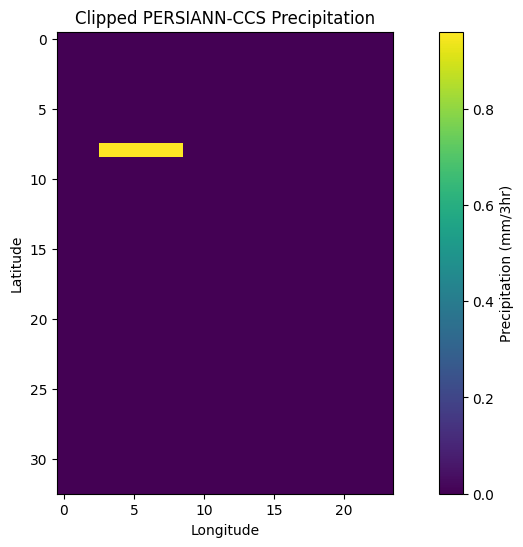

In [22]:
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.mask import mask

def read_persiann_ccs(file_path):
    ncols, nrows = 9000, 3000
    data = np.zeros((nrows, ncols), dtype=np.float32)  # Initialize data array

    with gzip.open(file_path, 'rb') as f:
        for i in range(nrows):
            for j in range(ncols):
                # Read two bytes from the file, big-endian format
                val = struct.unpack('>h', f.read(2))[0]
                # Convert to mm/3hr, handling the no-data value
                data[i, j] = np.nan if val == -9999 else val / 100.0

    return data

def convert_to_geotiff(data, geotiff_path):
    transform = from_origin(-180, 60, 0.04, 0.04)
    metadata = {
        'driver': 'GTiff',
        'height': data.shape[0],
        'width': data.shape[1],
        'count': 1,
        'dtype': 'float32',
        'crs': '+proj=latlong',
        'transform': transform
    }
    
    with rasterio.open(geotiff_path, 'w', **metadata) as dst:
        dst.write(data, 1)

def clip_raster_with_gpkg(raster_path, gpkg_path, clipped_raster_path):
    gdf = gpd.read_file(gpkg_path)
    gdf = gdf.to_crs(crs='+proj=latlong')
    
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, gdf.geometry, crop=True)
        out_meta = src.meta.copy()
        
        out_meta.update({
            'driver': 'GTiff',
            'height': out_image.shape[1],
            'width': out_image.shape[2],
            'transform': out_transform
        })
        
        with rasterio.open(clipped_raster_path, 'w', **out_meta) as dest:
            dest.write(out_image)

def plot_clipped_data(clipped_raster_path):
    with rasterio.open(clipped_raster_path) as src:
        data = src.read(1)
        plt.figure(figsize=(12, 6))
        plt.imshow(data, cmap='viridis', origin='upper')
        plt.colorbar(label='Precipitation (mm/3hr)')
        plt.title('Clipped PERSIANN-CCS Precipitation')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()

# Paths
file_path = '/home/hidrologia/Downloads/rgccs3h0300100.bin.gz'
geotiff_path = '/home/hidrologia/Downloads/rgccs3h0300100.tif'
gpkg_path = '/home/hidrologia/Pronostico_hidro/Inputs/Manduriacu_delimitada.gpkg'
clipped_raster_path = '/home/hidrologia/Downloads/clipped_rgccs3h0300100.tif'

# Read and convert the data to GeoTIFF
data = read_persiann_ccs(file_path)
convert_to_geotiff(data, geotiff_path)

# Clip the GeoTIFF with the geopackage shapefile
clip_raster_with_gpkg(geotiff_path, gpkg_path, clipped_raster_path)

# Plot the clipped data
plot_clipped_data(clipped_raster_path)
